# Automatic tagging 

- Applying deep learning concepts

# 1)- Importing key modules

In [0]:
#support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [0]:
import os
import pickle as pkl
import re
import string

In [0]:
# for data processing

import numpy as np
import itertools
import pandas as pd 
from sklearn.model_selection import train_test_split
import tqdm

In [4]:
# for text 

import nltk
import re 
from nltk import tokenize
import nltk
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
lemm = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
# for deep learning

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Input
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model

from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Conv1D, MaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping

from keras.utils import to_categorical

# For evaluation

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

Using TensorFlow backend.


In [0]:
# For visuals

import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, BoundaryNorm
% matplotlib inline 
pd.set_option('display.max_colwidth', 200)

In [7]:
! pip install version_information

In [8]:
# first install: pip install version_information
%reload_ext version_information
%version_information pandas,numpy,keras, sklearn,nltk, seaborn, matplotlib

Software,Version
Python,3.6.8 64bit [GCC 8.3.0]
IPython,5.5.0
OS,Linux 4.14.137+ x86_64 with Ubuntu 18.04 bionic
pandas,0.25.3
numpy,1.17.4
keras,2.2.5
sklearn,0.21.3
nltk,3.2.5
seaborn,0.9.0
matplotlib,3.1.1


# 2)- Reading Dataset

Thanks to PyData 2018: Gilbert Francois Talk

In [9]:
data=pd.read_pickle('messages-cls-ms.pkl')
data.shape

(3105, 5)

In [10]:
data.head()

,user,class,text,ts,key
0,Balaemar,8,I have to pick up my car from the garage tomorrow.,1.503303e+09,1503303350U035FRUCY
0,Balaemar,1,I have to leave at 15:45 on Thursday.,1.503303e+09,1503303350U035FRUCY
1,Ragaenys,2,I won’t be here tomorrow one day vacation,1.503302e+09,1503301710U4A2FRAQ4
2,Myke,1,Missed connection in Zurich.,1.503296e+09,1503296123U0MGNKETU
2,Myke,1,Will be about 5-10 mins late in the office,1.503296e+09,1503296123U0MGNKETU


In [11]:
data.tail()

,user,class,text,ts,key
1717,Overton,8,<@U0PSDKXHR|Overton> has joined the channel,1.462269e+09,1462269461U0PSDKXHR
1718,Balaemar,8,<@U035FRUCY|Balaemar> has joined the channel,1.462269e+09,1462269461U035FRUCY
1719,Eliar,8,<@U0A8NPHRD|Eliar> has joined the channel,1.462269e+09,1462269366U0A8NPHRD
1720,Caenraenos,8,<@U035AASB8|Caenraenos> set the channel topic: home office lateness general absence updates,1.462268e+09,1462267520U035AASB8
1721,Caenraenos,8,<@U035AASB8|Caenraenos> has joined the channel,1.462267e+09,1462267404U035AASB8


In [12]:
data['class'].unique()

array([8, 1, 2, 3, 6, 4, 7, 5])

# Class	Description
- 1	Too late, away during office hours or early leave
- 2	Holidays or scheduled free days
- 3	Home Office
 -4	Medical appointment
- 5	Ill, without consulting a medical
- 6	Work related absence (at client, conference)
- 7	In office announcement
- 8	Miscellanious

In [0]:
dict_classes = {
    1: 'late/early',
    2: 'holidays',
    3: 'home office',
    4: 'med app',
    5: 'ill',
    6: 'business',
    7: 'in office',
    8: 'miscellanious'
}

In [14]:
data['class'].value_counts()

8    874
1    793
3    593
2    200
7    192
6    163
5    147
4    143
Name: class, dtype: int64

In [0]:
df=data[['text','class']]

In [16]:
type(df)

pandas.core.frame.DataFrame

In [17]:
df.head()

,text,class
0,I have to pick up my car from the garage tomorrow.,8
0,I have to leave at 15:45 on Thursday.,1
1,I won’t be here tomorrow one day vacation,2
2,Missed connection in Zurich.,1
2,Will be about 5-10 mins late in the office,1


In [0]:
# Remove all rows which have no annotation
df = df.dropna()

In [19]:
df.shape

(3105, 2)

### checking missing value if any

In [20]:
df.isnull().sum()

text     0
class    0
dtype: int64

In [0]:
# further check
df['class'] = df.loc[:, 'class'].astype(np.uint8).values

### Separating X and y

In [0]:
X = df['text']
y = df['class']

In [23]:
X[:5]

0    I have to pick up my car from the garage tomorrow.
0                 I have to leave at 15:45 on Thursday.
1             I won’t be here tomorrow one day vacation
2                          Missed connection in Zurich.
2            Will be about 5-10 mins late in the office
Name: text, dtype: object

In [24]:
y[:5]

0    8
0    1
1    2
2    1
2    1
Name: class, dtype: uint8

# 3)- Pre-model process

In [0]:
# Embedding
max_features = 3000
maxlen = 50
embedding_size = 100

# Convolution
kernel_size = 5
filters = 64
pool_size = 4

# LSTM
lstm_output_size = 70

# Training
batch_size = 20
epochs = 12

### 3a)-Tokenizing

In [0]:

tokenizer = Tokenizer(num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True, split=' ', char_level=False)
tokenizer.fit_on_texts(X)
Xt = tokenizer.texts_to_sequences(X)

In [27]:
print(X.iloc[2])

I won’t be here tomorrow one day vacation


In [28]:
print(Xt[2])

[1, 352, 4, 127, 10, 187, 26, 258]


In [29]:
# word to index
word_index = tokenizer.word_index
num_words = len(word_index)
print('Number of words in the corpus: {}'.format(num_words))

Number of words in the corpus: 2480


In [30]:
len_list = np.array([len(x) for x in Xt])
mean_len = np.mean(len_list)
std_len = np.std(len_list)
print(mean_len, std_len)

8.438003220611916 5.3164683718103545


### 3b)-Multi Label Binarizer

In [31]:
yc = to_categorical(y-1)
yc[:10]

array([[0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

### 3c)-Sequence padding
Make all input vectors the same size by truncating or adding zeros.

In [0]:
Xts = sequence.pad_sequences(Xt, maxlen=maxlen, padding='post')

In [33]:
print(X[1])

I won’t be here tomorrow one day vacation


In [34]:
print(Xt[1])

[1, 14, 3, 20, 7, 45, 92, 11, 47]


In [35]:
print(Xts[1])

[ 1 14  3 20  7 45 92 11 47  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0]


### 3d)- Split dataset

In [0]:
X_train, X_test, y_train, y_test = train_test_split(Xts, yc, test_size=0.10, random_state=1)

In [37]:

print('X_train shape: {}'.format(X_train.shape))
print('X_test shape : {}'.format(X_test.shape))

print('y_train shape: {}'.format(y_train.shape))
print('y_test shape : {}'.format(y_test.shape))

X_train shape: (2794, 50)
X_test shape : (311, 50)
y_train shape: (2794, 8)
y_test shape : (311, 8)


# 4)- Model Building

In [0]:
def build_and_train_model(X_train, X_test, y_train, y_test, verbose=1):
    print('Build model...')
    model = Sequential()
    model.add(Embedding(max_features, embedding_size, input_length=maxlen))
    model.add(Dropout(0.25))
    model.add(Conv1D(filters,
                     kernel_size,
                     padding='valid',
                     activation='relu',
                     strides=1))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(LSTM(lstm_output_size))
    model.add(Dense(8))
    model.add(Activation('softmax'))

    callback = EarlyStopping(monitor='val_acc', patience=2) # avoid over-fitting

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    print('Training the model...')
    H = model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(X_test, y_test), callbacks=[callback], verbose=verbose)
  
    score, acc = model.evaluate(X_test, y_test, batch_size=batch_size)
    print('Test accuracy:', acc)
    return model, H, acc

### training the model

In [39]:
model, H, acc = build_and_train_model(X_train, X_test, y_train, y_test)

Build model...




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Training the model...
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 2794 samples, validate on 311 samples
Epoch 1/12





2794/2794 [==============================] - 7s 3ms/step - loss: 1.7608 - acc: 0.3253 - val_loss: 1.4135 - val_acc: 0.5531
Epoch 2/12
2794/2794 [==============================] - 4s 1ms/step - loss: 1.0163 - acc: 0.6568 - val_loss: 0.9321 - val_acc: 0.7203
Epoch 3/12
2794/2794 [==============================] - 4s 2ms/step - loss: 0.6890 - acc: 0.7609 - val_loss: 0.8568 - val_acc: 0.7299
Epoch 4/12
2794/2794 [==============================] - 4s 1ms/step - loss: 0.5213 - acc: 0.8296 - val_loss: 0.9311 - val_acc: 0.7395
Epoch 5/12
2794/2794 [==============================] - 4s 1ms/step - loss: 0.3821 - acc: 0.8848 - val_loss: 0.8301 - val_acc: 0.7621
Epoch 6/12
2794/2794 [

### Visualization

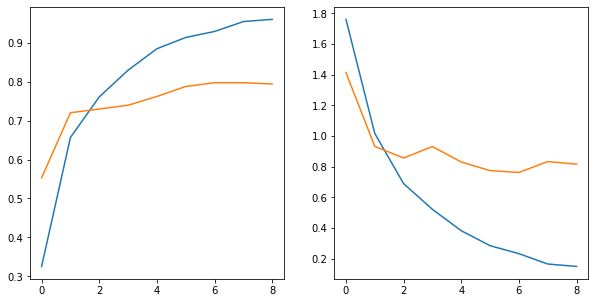

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(H.history['acc'], label='acc')
axs[0].plot(H.history['val_acc'], label='val_acc')
axs[1].plot(H.history['loss'], label='loss')
axs[1].plot(H.history['val_loss'], label='val_loss')

### Prediction

In [0]:
y_pred = model.predict(X_test)

In [42]:
y_pred[:5]

array([[1.4296027e-02, 3.0987903e-02, 1.0165272e-03, 3.8830213e-02,
        1.0152391e-02, 8.9695257e-01, 5.8402922e-03, 1.9240238e-03],
       [9.8405153e-01, 4.9233600e-04, 1.5476407e-03, 6.3508870e-03,
        3.7107014e-04, 5.3612812e-04, 5.8902340e-04, 6.0614343e-03],
       [1.1266606e-03, 5.0352942e-03, 9.4439918e-01, 6.9875008e-04,
        3.3388972e-02, 3.5643238e-03, 7.7970535e-03, 3.9897054e-03],
       [7.0141917e-03, 1.2736632e-01, 6.4794524e-03, 1.6101691e-03,
        6.9435053e-02, 3.7006758e-02, 7.3837095e-01, 1.2717175e-02],
       [5.4888092e-03, 5.8587235e-01, 6.8163369e-03, 2.1074729e-02,
        6.6963442e-02, 3.0004957e-01, 3.1807788e-03, 1.0553962e-02]],
      dtype=float32)

In [0]:
y_pred_class=np.argmax(y_pred, axis=1)

In [44]:
y_pred_class[:5]

array([5, 0, 2, 6, 1])

In [45]:
# true values
y_test[:5]

array([[0., 0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [0]:
y_test_class=np.argmax(y_test, axis=1)

In [47]:
print(classification_report(y_pred=y_pred_class, y_true=y_test_class))

              precision    recall  f1-score   support

           0       0.84      0.75      0.79        92
           1       0.59      0.81      0.68        16
           2       0.98      0.82      0.89        55
           3       0.61      0.79      0.69        14
           4       0.76      0.68      0.72        19
           5       0.64      0.93      0.76        15
           6       0.75      0.65      0.70        23
           7       0.80      0.87      0.83        77

    accuracy                           0.79       311
   macro avg       0.75      0.79      0.76       311
weighted avg       0.81      0.79      0.80       311



### confusion matrix

In [48]:
! pip install scikit-plot

In [49]:
cm = confusion_matrix(y_pred_class, y_test_class)
cm

array([[69,  1,  2,  2,  1,  0,  2,  5],
       [ 1, 13,  2,  0,  2,  0,  3,  1],
       [ 0,  0, 45,  0,  0,  0,  0,  1],
       [ 5,  1,  0, 11,  1,  0,  0,  0],
       [ 0,  0,  3,  0, 13,  0,  0,  1],
       [ 4,  1,  0,  1,  1, 14,  1,  0],
       [ 2,  0,  1,  0,  0,  0, 15,  2],
       [11,  0,  2,  0,  1,  1,  2, 67]])

<Figure size 432x288 with 0 Axes>

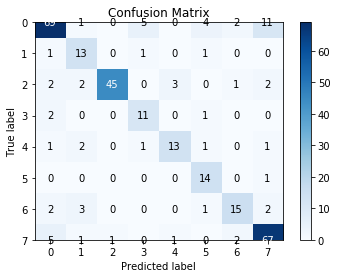

In [50]:
import scikitplot as skplt
plt.figure()
skplt.metrics.plot_confusion_matrix(y_pred=y_pred_class, y_true=y_test_class)
plt.show()

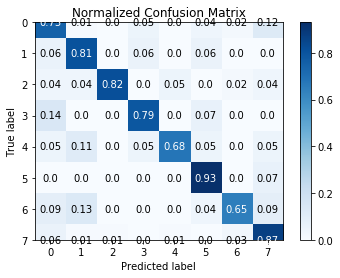

In [51]:
skplt.metrics.plot_confusion_matrix(y_pred=y_pred_class, y_true=y_test_class, normalize=True)

# 5)- Training an ensemble model

Since we do early stopping, to minimise overfitting, the model is not fully trained yet. The effect of random initialisation is noticable. Hence, when training e.g. 10 times from scratch, you end up with 10 models with different performance. An idea to smooth this effect is to train multiple times and use all models for the prediction. Add all resulting output vectors and take the $argmax$. This will be your final prediction.

In [52]:
n_models = 10

model_list = []
H_list = []
acc_list = []
for i in range(n_models):
    print('Training model {}'.format(i+1))
    _model, _H, _acc = build_and_train_model(X_train, X_test, y_train, y_test, verbose=0)
    model_list.append(_model)
    H_list.append(_H)
    acc_list.append(_acc)

Training model 1
Build model...
Training the model...
311/311 [==============================] - 0s 641us/step
Test accuracy: 0.8295819968272635
Training model 2
Build model...
Training the model...
311/311 [==============================] - 0s 504us/step
Test accuracy: 0.8167202535932854
Training model 3
Build model...
Training the model...
311/311 [==============================] - 0s 621us/step
Test accuracy: 0.7813504830817317
Training model 4
Build model...
Training the model...
311/311 [==============================] - 0s 531us/step
Test accuracy: 0.8295819964439539
Training model 5
Build model...
Training the model...
311/311 [==============================] - 0s 515us/step
Test accuracy: 0.8006430845168626
Training model 6
Build model...
Training the model...
311/311 [==============================] - 0s 528us/step
Test accuracy: 0.819935692276602
Training model 7
Build model...
Training the model...
311/311 [==============================] - 0s 627us/step
Test accuracy: 0.800

In [53]:
print('Mean test accuracy: {:.3f}'.format(np.mean(np.array(acc_list))))

Mean test accuracy: 0.810


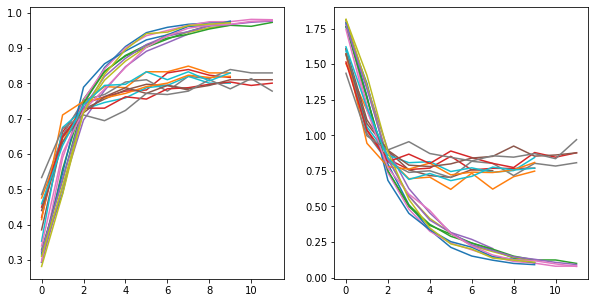

In [54]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
for H in H_list:
    axs[0].plot(H.history['acc'], label='acc')
    axs[0].plot(H.history['val_acc'], label='val_acc')
    axs[1].plot(H.history['loss'], label='loss')
    axs[1].plot(H.history['val_loss'], label='val_loss')

In [0]:
y_pred_list = []
for index in range(len(X_test)):
    y_pred = np.zeros(8)
    for model in model_list:
        y_pred += model.predict(X_test[index][np.newaxis])[0]
    y_pred_list.append(y_pred)
    
y_pred = np.array(y_pred_list)

In [56]:
y_pred[:5]

array([[6.06836690e-02, 1.15092631e+00, 2.59961855e-02, 1.07874860e-01,
        1.80825325e-01, 8.24533595e+00, 2.01094276e-01, 2.72634701e-02],
       [9.95165795e+00, 4.50354194e-03, 5.51498526e-03, 3.18268465e-03,
        7.37360186e-03, 1.22927560e-03, 7.10192406e-03, 1.94357896e-02],
       [9.35124359e-03, 3.28639589e-03, 9.95521253e+00, 2.23394008e-03,
        1.95664097e-02, 3.73602711e-03, 2.32457437e-03, 4.28897730e-03],
       [6.06140460e-02, 6.09017556e-02, 9.76644355e-03, 4.00934787e-03,
        1.17930482e-01, 2.80770474e-02, 9.60408902e+00, 1.14611726e-01],
       [1.37795061e-01, 7.45367890e+00, 3.33010191e-02, 1.94201409e-01,
        1.70255031e-01, 1.03279495e+00, 7.34618501e-01, 2.43355169e-01]])

In [0]:
y_pred_class=np.argmax(y_pred, axis=1)

In [58]:
y_pred_class[:5]

array([5, 0, 2, 6, 1])

In [59]:
# true values
y_test[:5]

array([[0., 0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [0]:
y_test_class=np.argmax(y_test, axis=1)

In [61]:
y_test_class[:5]

array([6, 0, 2, 6, 1])

In [62]:
accuracy_score(y_pred_class, y_test_class)

0.864951768488746

In [63]:
print(classification_report(y_pred_class, y_test_class))

              precision    recall  f1-score   support

           0       0.89      0.85      0.87        97
           1       0.88      0.78      0.82        18
           2       0.91      0.94      0.93        53
           3       0.71      0.83      0.77        12
           4       0.68      1.00      0.81        13
           5       0.93      0.82      0.87        17
           6       0.78      0.86      0.82        21
           7       0.88      0.85      0.87        80

    accuracy                           0.86       311
   macro avg       0.83      0.87      0.84       311
weighted avg       0.87      0.86      0.87       311



<Figure size 432x288 with 0 Axes>

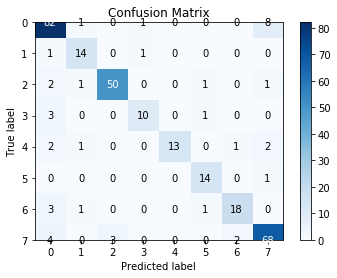

In [64]:
import scikitplot as skplt
plt.figure()
skplt.metrics.plot_confusion_matrix(y_pred=y_pred_class, y_true=y_test_class)
plt.show()

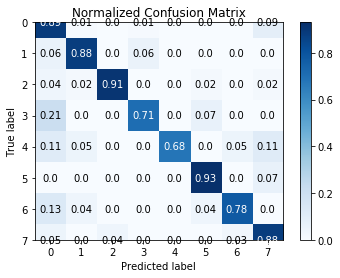

In [65]:
skplt.metrics.plot_confusion_matrix(y_pred=y_pred_class, y_true=y_test_class, normalize=True)

# 6)- Checking out of sample data

In [0]:
def tag_message(message):
    X_new = tokenizer.texts_to_sequences([message])
    x1_new = sequence.pad_sequences(X_new, maxlen=maxlen, padding='post')
    y_pred_list = []
    for model in model_list:
        y_pred_list.append(model.predict(x1_new))
    y_pred = np.argmax(np.sum(np.array(y_pred_list), axis=0) / 10.0)
    print('{:>20} | {}'.format(dict_classes[y_pred], message))

In [0]:
tag_message('My alarm clock was not set properly. I come to the office asap.')
tag_message('It is my scheduled day off.')
tag_message('See you on Wednesday.')
tag_message('Not feeling well today, I had to vomit.')
tag_message('I work at home on Tuesday.')
tag_message('This morning I have a meeting at ACME.')
tag_message('The roads are super slippery, will miss the daily')
tag_message('get well soon!')
tag_message('I\'m away for a long lunch between 12:00 and 15:30')
tag_message('I have an appointment at the physio.')

# 7)-Transfer learning with pretrained embeddings

### 7.1)- USe GloVe Word - Embedding 

In [68]:
# download the file
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2019-11-28 18:03:22--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2019-11-28 18:03:22--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2019-11-28 18:03:23--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

glove

In [69]:
# unzip it

!unzip glove*.zip

Archive:  glove.6B.zip
replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: glove.6B.50d.txt        
replace glove.6B.100d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: glove.6B.100d.txt       
replace glove.6B.200d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: glove.6B.200d.txt       
replace glove.6B.300d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: glove.6B.300d.txt       


In [70]:
# Get the exact path of where the embedding vectors are extracted using
!ls
!pwd

glove.6B.100d.txt  glove.6B.50d.txt  messages-cls-mc.pkl
glove.6B.200d.txt  glove.6B.zip      messages-cls-ms.pkl
glove.6B.300d.txt  glove.6B.zip.1    sample_data
/content


In [71]:
# Index the vectors

print('Indexing word vectors.')

embeddings_index = {}
f = open('glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 400000 word vectors.


### 7.2)- loading file for pretrained embeddings

In [72]:
embeddings_index = {}
with open('glove.6B.100d.txt', 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [73]:
embeddings_index['home'].shape

(100,)

In [74]:
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
print(embedding_matrix.shape)

(2481, 100)


### 7.3)-Model Building

In [75]:
print('Build model...')

model = Sequential()
# model.add(Input(shape=(maxlen,), dtype='int32'))
model.add(Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], weights=[embedding_matrix], input_length=maxlen, trainable=False))
model.add(Dropout(0.25))
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
model.add(MaxPooling1D(pool_size=pool_size))
model.add(LSTM(lstm_output_size))
model.add(Dense(8))
model.add(Activation('softmax'))

callback = EarlyStopping(monitor='val_acc', patience=1)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
H = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_test, y_test), callbacks=[callback])
score, acc = model.evaluate(X_test, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Build model...
Train...
Train on 2794 samples, validate on 311 samples
Epoch 1/12
2794/2794 [==============================] - 8s 3ms/step - loss: 1.6045 - acc: 0.4366 - val_loss: 1.2772 - val_acc: 0.5627
Epoch 2/12
2794/2794 [==============================] - 4s 2ms/step - loss: 1.1519 - acc: 0.6120 - val_loss: 1.1387 - val_acc: 0.6367
Epoch 3/12
2794/2794 [==============================] - 4s 2ms/step - loss: 0.8886 - acc: 0.7101 - val_loss: 0.8542 - val_acc: 0.6977
Epoch 4/12
2794/2794 [==============================] - 4s 1ms/step - loss: 0.7338 - acc: 0.7563 - val_loss: 0.7917 - val_acc: 0.7235
Epoch 5/12
2794/2794 [==============================] - 4s 1ms/step - loss: 0.5747 - acc: 0.8142 - val_loss: 0.6377 - val_acc: 0.7942
Epoch 6/12
311/311 [==============================] - 0s 588us/step
Test score: 0.6290366411975725
Test accuracy: 0.7813504826984221


In [0]:
y_pred = model.predict(X_test)

### 7.4)- Results

In [77]:
accuracy_score(y_pred=np.argmax(y_pred, axis=1), y_true=np.argmax(y_test, axis=1))

0.7813504823151125

In [78]:
print(classification_report(y_pred=np.argmax(y_pred, axis=1), y_true=np.argmax(y_test, axis=1)))

              precision    recall  f1-score   support

           0       0.75      0.86      0.80        92
           1       0.71      0.75      0.73        16
           2       0.94      0.82      0.87        55
           3       0.74      1.00      0.85        14
           4       0.58      0.37      0.45        19
           5       0.76      0.87      0.81        15
           6       0.55      0.52      0.53        23
           7       0.87      0.79      0.83        77

    accuracy                           0.78       311
   macro avg       0.74      0.75      0.73       311
weighted avg       0.78      0.78      0.78       311



In [79]:
cm = confusion_matrix(y_pred=np.argmax(y_pred, axis=1), y_true=np.argmax(y_test, axis=1))
cm

array([[79,  0,  0,  3,  2,  0,  3,  5],
       [ 1, 12,  0,  0,  0,  0,  2,  1],
       [ 6,  0, 45,  0,  0,  3,  1,  0],
       [ 0,  0,  0, 14,  0,  0,  0,  0],
       [ 5,  1,  2,  2,  7,  0,  0,  2],
       [ 0,  0,  0,  0,  0, 13,  2,  0],
       [ 7,  3,  0,  0,  0,  0, 12,  1],
       [ 8,  1,  1,  0,  3,  1,  2, 61]])

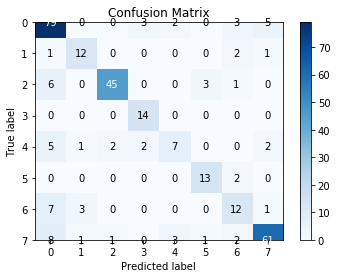

In [80]:
skplt.metrics.plot_confusion_matrix(y_pred=np.argmax(y_pred, axis=1), y_true=np.argmax(y_test, axis=1))
plt.show()

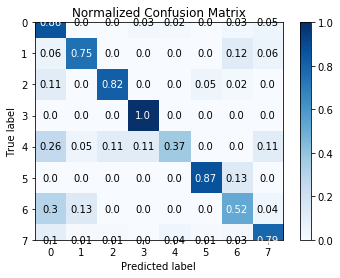

In [81]:
skplt.metrics.plot_confusion_matrix(y_pred=np.argmax(y_pred, axis=1), y_true=np.argmax(y_test, axis=1), normalize=True)
plt.show()